In [1]:
import os
import numpy as np
from scipy.optimize import curve_fit
import pickle
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy import signal
import matplotlib.pyplot as plt
%matplotlib notebook

# Demo Summary
In this demo, I show how I use the spectrum of an arc lamp to calculate the most accurate pixel to wavelength conversion or 'wavelength solution'. Why? An accurate wavelength solution allows us to accurately measure other wavelength dependent properties of the spectrum, such as identification of elements, elemental abundances and radial velocities.

The wavelength solution is similar to the bar at the bottom of a map that tells you the distance scale of the current image (a bar of this length/pixels is equal to 10 miles)

# Step 1.
## Load in the data, both the spectrum that already contains an initial wavelength soltution and the list of expected lines.

In [2]:
wavelength,arc=pickle.load(open( "DS_Demo_Data_arclamp.p", "rb" ))
arc_line_list = pd.read_csv('EMIR_arclamp_line_list.txt', sep = '\t')
arc_line_list

,wavelength,strength,element
0,19582.455,1000,Ne
1,19822.920,3550,Ar
2,19950.900,1000,Ar
3,19971.180,7900,Ar
4,20031.140,990,Ar
...,...,...,...
84,25512.190,1500,NaN
85,25668.020,790,NaN
86,26027.800,240,NaN
87,26050.600,320,NaN


In [3]:
arc_line_list = arc_line_list.dropna()
arc_line_list

,wavelength,strength,element
0,19582.455,1000,Ne
1,19822.920,3550,Ar
2,19950.900,1000,Ar
3,19971.180,7900,Ar
4,20031.140,990,Ar
...,...,...,...
68,24376.330,100,Ne
69,24371.661,7400,Ne
70,24378.260,3800,Ne
71,24390.011,360,Ne


In [4]:
line_wav=np.array(arc_line_list['wavelength'],dtype=float)
elements=np.array(arc_line_list['element'])

## Plot both of them and examine how far off the wavelength solution of the data is compared with the expected wavelengths of the lines.

<IPython.core.display.Javascript object>


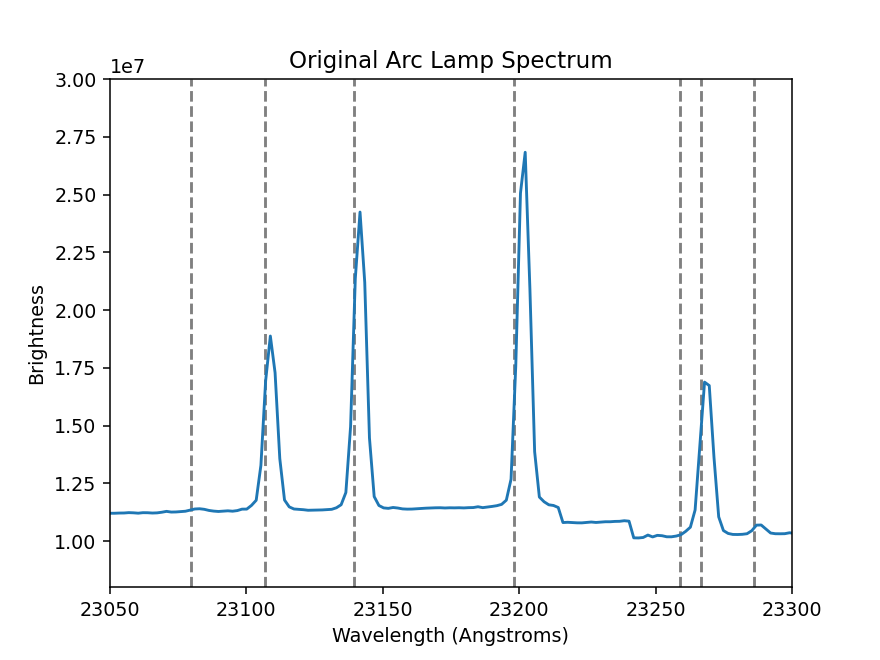

In [5]:
plt.figure()
for w in line_wav:
    plt.axvline(w,linestyle='--',c='gray')
plt.plot(wavelength, arc)
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Brightness')
plt.title('Original Arc Lamp Spectrum')
plt.xlim(23050,23300);
plt.ylim(.8e7,.3e8);

It looks like the data (blue) are shifted to the right of where we expect the lines(gray).

# Step 2
## Find the matches between the expected line list and the peaks in the data

[ 233  234  235  279  360  392  418  492  504  539  564  632  675  707
  726  853  880  898  948  993 1094 1126 1187 1190 1191 1228 1295 1318
 1374 1411 1512 1602 1610 1703 1725 1823 1928 1950 1987 2063 2078 2089
 2090 2120 2179 2188 2238 2317 2335 2370 2409 2474 2585 2626 2668 2747
 2809 2817 2824 2893 2894 2930 2980 2981 3000 3012 3013 3014 3047 3048
 3049 3074 3132 3140 3141 3142 3152 3153]


<IPython.core.display.Javascript object>


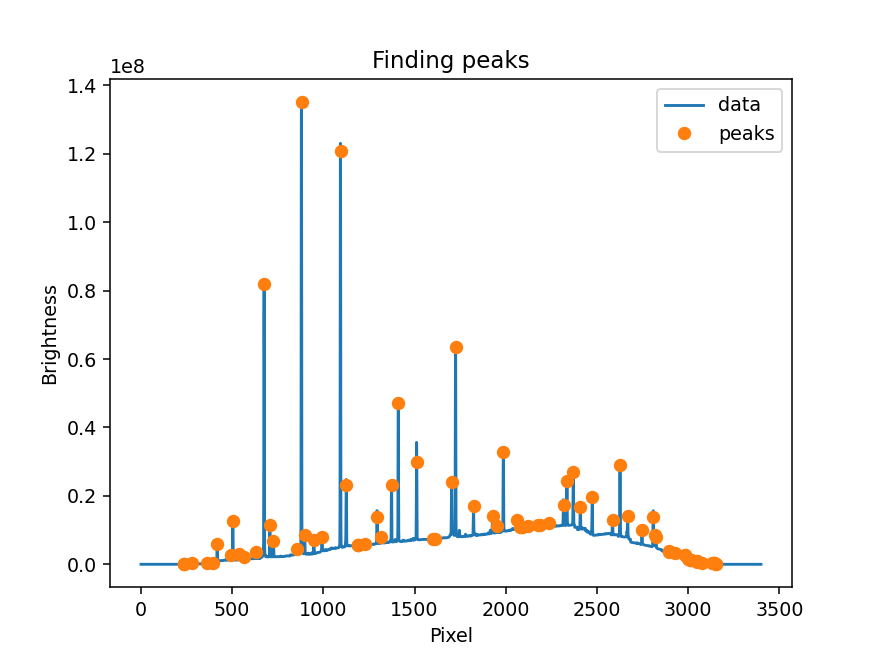

In [6]:
#Getting the peaks first:

# After testing, a lower limit of 1 included too many very faint "lines" and 
# greater than 5 did not increase the number of peaks detected
peak_widths = np.arange(2, 5)
peak_indices = signal.find_peaks_cwt(arc, peak_widths)
print(peak_indices)

plt.figure()
plt.plot(arc,label='data')
plt.plot(peak_indices,arc[peak_indices],'o',label='peaks')
plt.xlabel('Pixel')
plt.ylabel('Brightness')
plt.title('Finding peaks')
plt.legend()

expected [19582.455 19822.92  19950.9   19971.18  20031.14  20074.41  20192.71
 20267.77  20287.97  20322.56  20355.771 20621.86  20652.77  20739.22
 20816.72  20848.41  20857.62  20991.84  21047.013 21338.71  21378.89
 21475.96  21509.615 21540.08  21714.039 22045.58  22083.21  22253.432
 22275.9   22392.5   22412.9   22434.265 22472.92  22536.528 22624.5
 22667.971 22693.959 22884.08  22971.1   23079.8   23106.784 23139.51
 23198.    23259.1   23266.619 23285.9   23379.343 23571.764 23642.934
 23708.13  23715.599 23803.    23851.54  23918.541 23957.931 23962.964
 23973.06  23978.372 23984.701 24093.528 24105.148 24156.486 24168.025
 24225.535 24256.224 24376.33  24371.661 24378.26  24390.011 24450.3  ]
matched [19584.77 19825.24 19953.26 19974.02 20034.57 20077.82 20195.46 20269.85
 20269.85 20325.21 20358.08 20624.5  20655.64 20742.14 20819.99 20819.99
 20819.99 20994.72 21050.08 21342.45 21382.24 21479.12 21479.12 21543.13
 21717.86 22048.29 22086.35 22255.89 22255.89 22437.54 2243

<IPython.core.display.Javascript object>


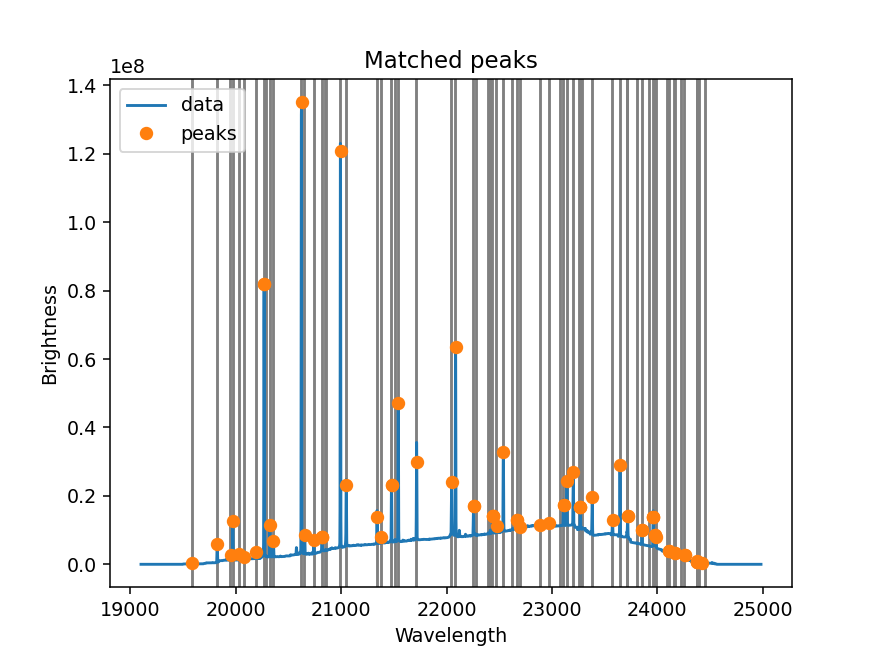

In [7]:
#Now getting the matches

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx],idx


matched_wav=np.array([find_nearest(wavelength[peak_indices], wav)[0] for wav in line_wav]) #wavelength
matched_inds=np.array([find_nearest(wavelength[peak_indices], wav)[1] for wav in line_wav])

print('expected',line_wav) # arc lamp line list
print('matched',matched_wav) # wavelength array
# print(matched_inds) #indices into local maxes
# print(peak_indices[matched_inds])

############################
plt.figure()
for l in line_wav:
    plt.axvline(l,c='gray')
plt.plot(wavelength,arc,label='data')
plt.plot(matched_wav,arc[peak_indices[matched_inds]],'o',label='peaks')
plt.xlabel('Wavelength')
plt.ylabel('Brightness')
plt.title('Matched peaks')
plt.legend()

Next I investigate the observed and expected wavelengths to confirm that they have been matched correctly.

observed - expected [ 2.315  2.32   2.36   2.84   3.43   3.41   2.75   2.08  18.12   2.65
  2.309  2.64   2.87   2.92   3.27  28.42  37.63   2.88   3.067  3.74
  3.35   3.16  30.495  3.05   3.821  2.71   3.14   2.458 20.01  45.04
 24.64   3.275  2.68   3.082 46.59   3.119  3.081  3.26   2.74  30.71
  3.726  2.14   4.2   10.57   3.051 16.23   2.777  2.386  2.146  9.61
  2.141 51.41   2.87  43.129  3.739  1.294  2.45   2.862  2.919 13.462
  1.842 14.514  2.975 31.965  1.276  0.54   1.749  1.39  13.141 30.18 ]
Mean, Median: 9.358799999998935 3.073999999998705


<IPython.core.display.Javascript object>


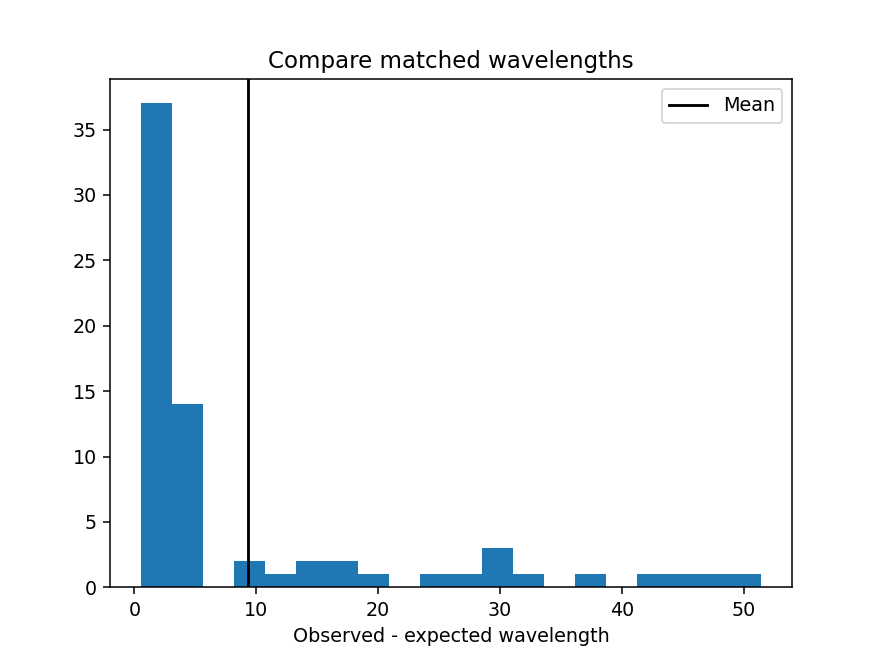

After removing large differences: [2.315 2.32  2.36  2.84  3.43  3.41  2.75  2.08  2.65  2.309 2.64  2.87
 2.92  3.27  2.88  3.067 3.74  3.35  3.16  3.05  3.821 2.71  3.14  2.458
 3.275 2.68  3.082 3.119 3.081 3.26  2.74  3.726 2.14  4.2   3.051 2.777
 2.386 2.146 2.141 2.87  3.739 1.294 2.45  2.862 2.919 1.842 2.975 1.276
 0.54  1.749 1.39 ]


In [8]:
diff_init=abs(matched_wav-line_wav)
print('observed - expected',diff_init)
print('Mean, Median:',np.mean(diff_init),np.median(diff_init))

plt.figure()
plt.hist(diff_init,bins=20)
plt.xlabel('Observed - expected wavelength')
plt.axvline(np.mean(diff_init),c='k',label='Mean')
plt.title('Compare matched wavelengths')
plt.legend()

# Remove matches with differences greater than the mean
filt=diff_init<np.mean(diff_init)

line_wav2=line_wav[filt]
matched_wav2=matched_wav[filt]

final_peaks=peak_indices[matched_inds][filt]
print('After removing large differences:', abs(matched_wav2-line_wav2))

# Step 3
## Fit each matched line with a gaussian to calculate the most accurate line center

In [9]:
def gaus2(x,a,x0,sigma,b):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))+b

def fit_gauss(xx,min_pix,max_pix,flat_spec,pix, verbose=False):
    try:
        popt, pcov = curve_fit(gaus2, xx, flat_spec[xx], p0 = [flat_spec[pix], pix, 2.,flat_spec[min_pix]])#,
#                                   bounds=([0,pk_val-15.,0,0], [sci_sky[pk_val],pk_val+15.,3./2.355,sci_sky[min_pix]]))
        color='g'
        perr = np.sqrt(np.diag(pcov))
        if verbose == True:        
            print('popt',popt)
            print('perr',perr)

    except RuntimeError:
        if verbose == True:        
            print(pix,'runtime')
        popt=[0,pix,0,flat_spec[min_pix]]
        perr=[-1,-1,-1,-1]
        color='r'
    except TypeError:
        if verbose == True:
            print(pix, 'type error')
        popt=[0,pix,0,flat_spec[min_pix]]
        perr=[-1,-1,-1,-1]
        color='r'
    return popt,perr,color
    
def check_fit(gauss, popt, perr, color, pix, verbose=False):
    if 2.355*popt[2]<0 or 2.355*popt[2]>5:#or perr[1]>10
        if verbose == True:
            print('bad FWHM',popt[0],popt[1],popt[2],popt[2]*2.355)
        bad=True
        color='r'
    elif max(gauss)/min(gauss)<1.1:
        if verbose == True:
            print('too faint',popt[0],popt[1],popt[2]*2.355,max(gauss)/min(gauss))
        bad=True
        color='orange'
    elif np.isinf(perr[0])==True:
        bad=True
        if verbose == True:
            print('inf errors')#,popt, perr)
        color='darkred'
    elif abs(pix-popt[1])>1:
        if verbose == True:
            print('fit the wrong line',pix,popt[1],abs(pix-popt[1]))
        bad=True
    else:
        bad=False
        color=color
        
    return color,bad

def get_fitted_centroids(flat_spec,matched_pix, to_plot='yes', verbose=False):
    local_min = (np.diff(np.sign(np.diff(flat_spec))) > 0).nonzero()[0] + 1 # local min
     
    sigs=[];bad=[];peaks=[];amps=[]
    
    if to_plot=='yes':
        plt.figure()
        plt.plot(flat_spec,c='k',label='Data')
    
    for j,pix in enumerate(matched_pix):

        # need to find the outer bounds of the line
        val,ind=find_nearest(local_min, pix) #min
        if val < pix:
            min_pix=val+1
            max_pix=local_min[ind+1]-1
        elif val>pix:
            max_pix=val+1
            min_pix=local_min[ind-1]-1

        xx=np.arange(min_pix,max_pix)
        popt,perr,color=fit_gauss(xx,min_pix,max_pix,flat_spec,pix)
        
        sigs.append(popt[2])
        peaks.append(popt[1])
        amps.append(popt[0])
        
        xx2 = np.arange(min_pix, max_pix, (max_pix-min_pix)/100)
        color,bad_check = check_fit(gaus2(xx2,*popt), popt, perr, color, pix, verbose)
        
        if bad_check == True:
            bad.append(j)
            
#         diff=gaus2(xx,*popt)-flat_spec[xx]
        
        if to_plot=='yes':
            plt.plot(xx2, gaus2(xx2, *popt),'o-',c=color,label='Fit')
#             plt.plot(pix,flat_spec[pix],'o',c='c')#,label='Data')
#             plt.plot(popt[1],flat_spec[pix],'o',c='b',label='Peak')
            plt.plot(min_pix,flat_spec[min_pix],'o',c='magenta',label='End points')
            plt.plot(max_pix,flat_spec[max_pix],'o',c='magenta')
            plt.title('Fitting gaussians to lines')
            plt.xlabel('Pixel')
            plt.ylabel('Brightness')
            if j ==0:
                plt.legend()
        if verbose == True:
            print('----------------------------')
    sigs=np.array(sigs);peaks=np.array(peaks);amps=np.array(amps)
    print('bad inds:', bad)
    good=np.array([j for j in range(len(matched_pix)) if j not in bad])
    #print 'good inds',good
    #print peaks[good]
    return peaks,sigs,amps,good

<IPython.core.display.Javascript object>


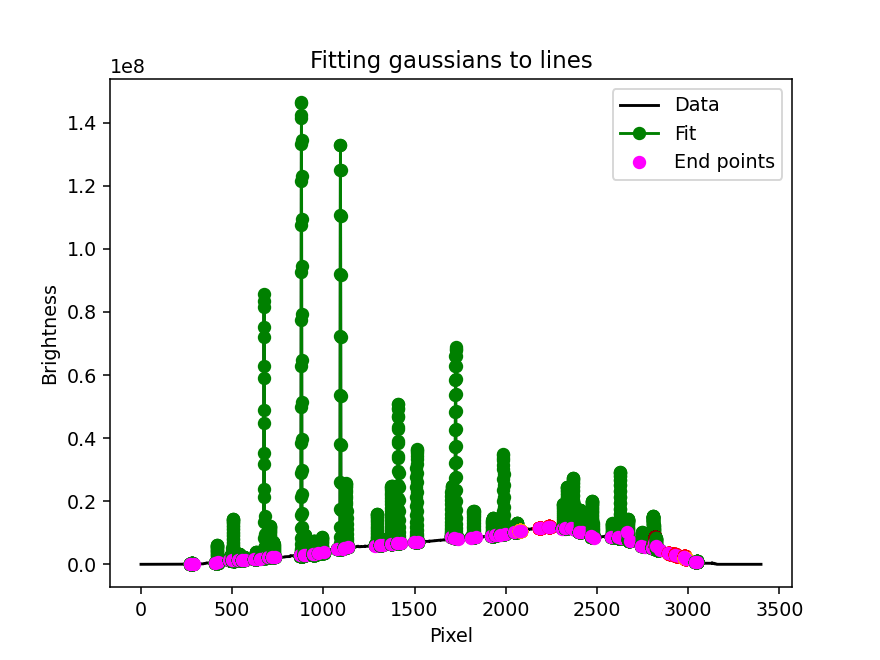

bad inds: [28, 29, 30, 42, 43, 45, 46, 47, 48, 50]


C:\Users\amy\anaconda3\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\amy\anaconda3\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\amy\anaconda3\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [10]:
fit_peaks,sigs,amps,good_fits=get_fitted_centroids(arc, final_peaks , to_plot='yes', verbose = False)

# Step 4
## Calculate the solution for wavelength as a function of pixel

<IPython.core.display.Javascript object>


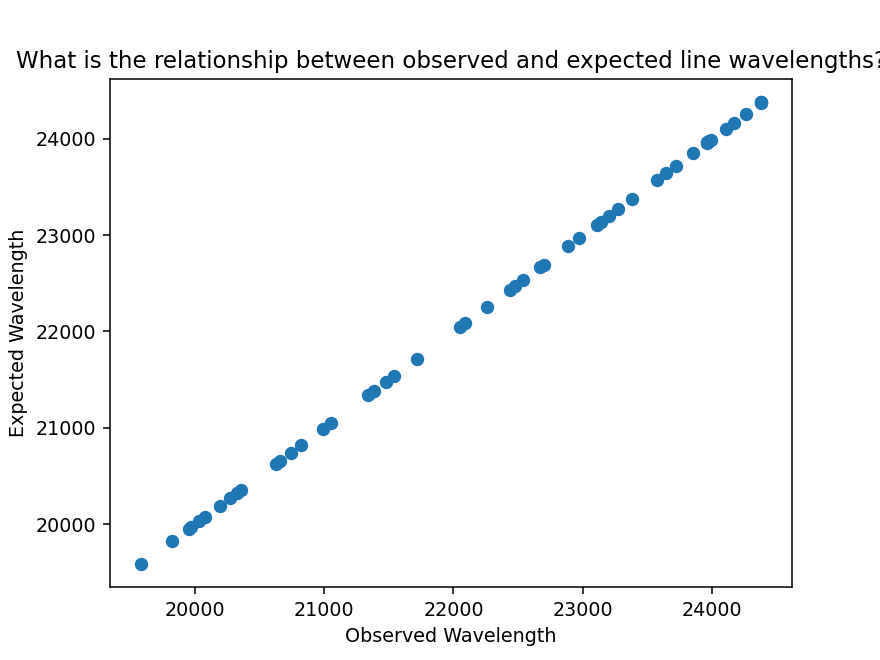

In [11]:
plt.figure()
plt.plot(matched_wav2,line_wav2,'o',label='Data')
plt.xlabel('Observed Wavelength')
plt.ylabel('Expected Wavelength')
plt.title('What is the relationship between observed and expected line wavelengths?');

## The relationship between observed and expected line wavelengths appears to be linear.

In [12]:
def calc_fit(deg,final_pix,final_wav,title):
    poly_reg = PolynomialFeatures(degree=deg)
    X_poly = poly_reg.fit_transform(final_pix.reshape(-1,1))
    pol_reg = LinearRegression(fit_intercept=False)
    pol_reg.fit(X_poly, final_wav)
    coeffs=pol_reg.coef_
    print(coeffs)
    wav_pred = pol_reg.predict(poly_reg.fit_transform(final_pix.reshape(-1,1)))
    rmse = np.sqrt(mean_squared_error(final_wav, wav_pred))
    print('rmse',rmse)

    diff_wav=final_wav-wav_pred

    n_std=2
    good1=np.where((abs(diff_wav)<n_std*np.std(diff_wav)))[0]
    bad1=np.where((abs(diff_wav)>np.std(diff_wav)))[0]
    print(good1)
    print(len(diff_wav))
    r2=r2_score(final_wav, wav_pred)
    print('r2',r2)

    good_rmse = np.sqrt(mean_squared_error(final_wav[good1], wav_pred[good1])) #same as np.std
    print(good_rmse)
    
    
    plt.figure()
    plt.plot(final_pix, wav_pred, color='k',label='Prediction')
    plt.plot(final_pix, final_wav,'o',label='Data',c='g')
    plt.plot(final_pix[bad1],final_wav[bad1],'o',label='Bad',c='r')
    plt.xlabel('Pixels')
    plt.ylabel('Wavelength (Angstroms)')
    plt.legend()
    plt.title(title)
    ###############

    plt.figure()
    plt.xlabel('Pixels');plt.ylabel('Data-fit (Angstroms)')
    plt.plot(final_pix,diff_wav,'o',c='r')
    plt.title('RMSE: '+str(round(rmse, 4)))#+';'+str(round(good_rmse,4)))
    plt.axhline(np.mean(diff_wav),c='gray')
    plt.axhline(np.mean(diff_wav)+2*np.std(diff_wav),linestyle='--',c='gray')
    plt.axhline(np.mean(diff_wav)-2*np.std(diff_wav),linestyle='--',c='gray')
    plt.plot(final_pix[good1],diff_wav[good1],'o',c='g')
    ##########################

    full_wav_pred=pol_reg.predict(poly_reg.fit_transform(np.arange(len(arc)).reshape(-1,1)))

#     plt.figure()
#     for l in final_wav[good1]:
#         plt.axvline(l,c='gray')
#     for l2 in wav_pred:
#         plt.axvline(l2, c='k')
#     plt.plot(full_wav_pred,arc,label='fit')
#     plt.xlabel('Wavelength')
#     plt.ylabel('Brightness')
#     # plt.plot(wavelength,arc,label='orig')
#     plt.legend()
#     # plt.xlim()

    return full_wav_pred, good1, coeffs

41 [ 278.5431506   417.74246481  491.4637525   503.30861263  538.59089046
  563.13146681  631.44369416  674.84745601  706.57037406  725.77351511
  879.56827429  897.54118667  947.64214302  992.30862575 1093.44695507
 1125.28880132 1294.0612388  1317.33399278 1373.43936941 1410.48999767
 1511.04201679 1702.7271224  1724.48372409 1822.93810567 1927.4323984
 1949.7564898  1986.47850872 2062.46252914 2316.0493128  2334.97151187
 2369.70518188 2408.43139085 2473.5537523  2584.78632297 2625.92376979
 2667.84414805 2746.54685233 2808.3256906  2808.3256906  2823.29475042
 3046.77764976]
[1.90999912e+04 1.73009360e+00]
rmse 0.7865963240146655
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 31 32 33 34 35 36 37 39 40]
41
r2 0.9999997016740982
0.3026073359060382


<IPython.core.display.Javascript object>


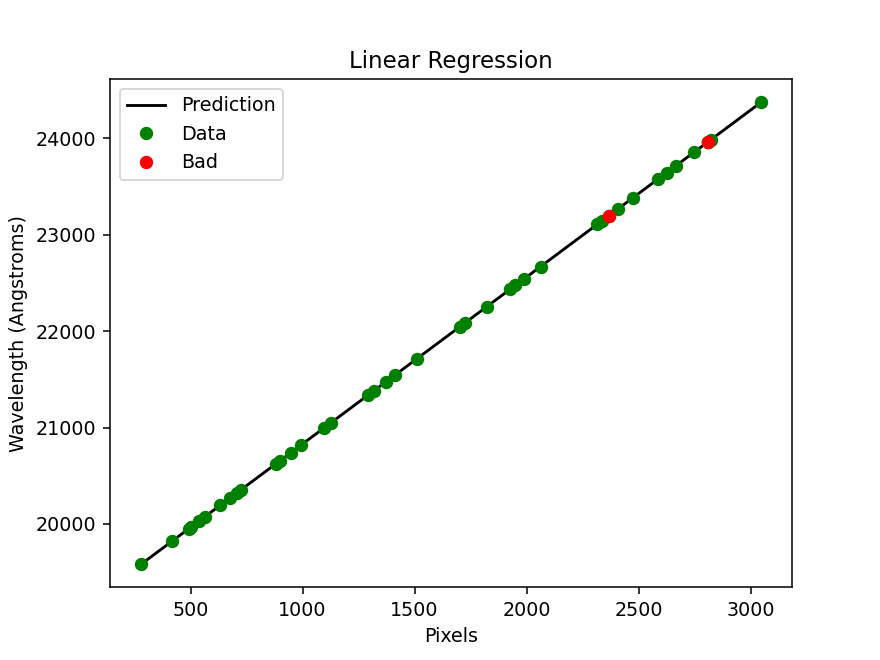

<IPython.core.display.Javascript object>


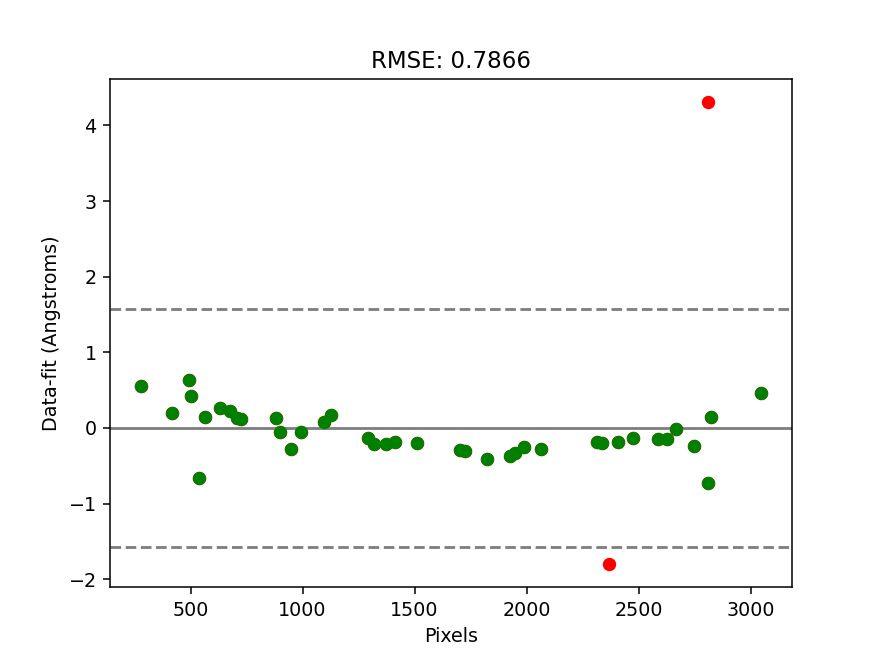

In [13]:
final_pix=np.array(fit_peaks[good_fits])#local_max[matched_inds]
final_wav=np.array(line_wav2[good_fits])
print(len(final_pix),final_pix)
#################################
updated_wav,good1,coeffs=calc_fit(1,final_pix,final_wav, 'Linear Regression')

## There is some structure in the residuals which indicates that the data will be better fit by a higher order polynomial.

[ 1.91001283e+04  1.73082799e+00 -1.22061415e-06  3.55505181e-10]
rmse 0.7167159197911562
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 31 32 33 34 35 36 37 39 40]
41
r2 0.9999997523255316
0.30966927285189116


<IPython.core.display.Javascript object>


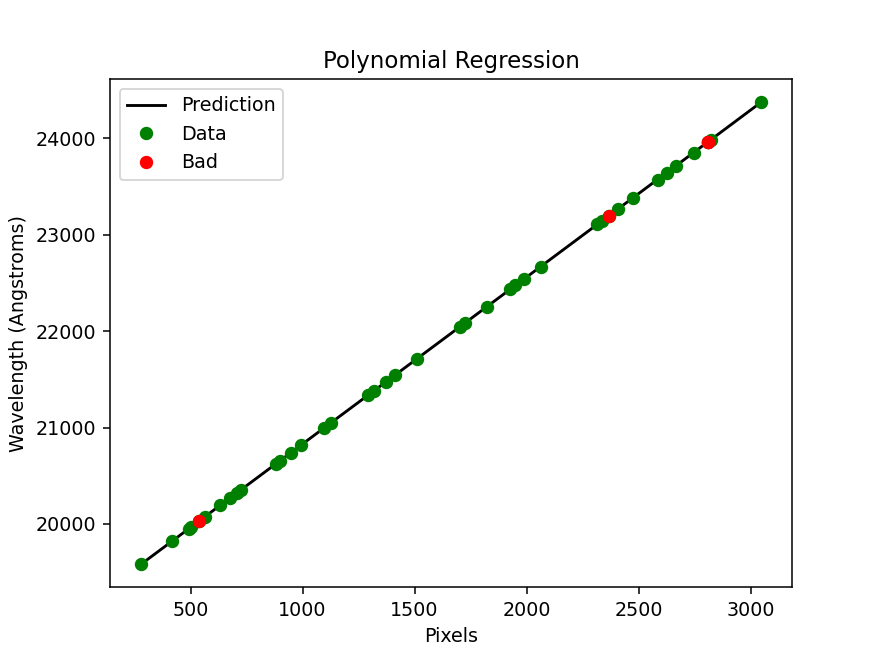

<IPython.core.display.Javascript object>


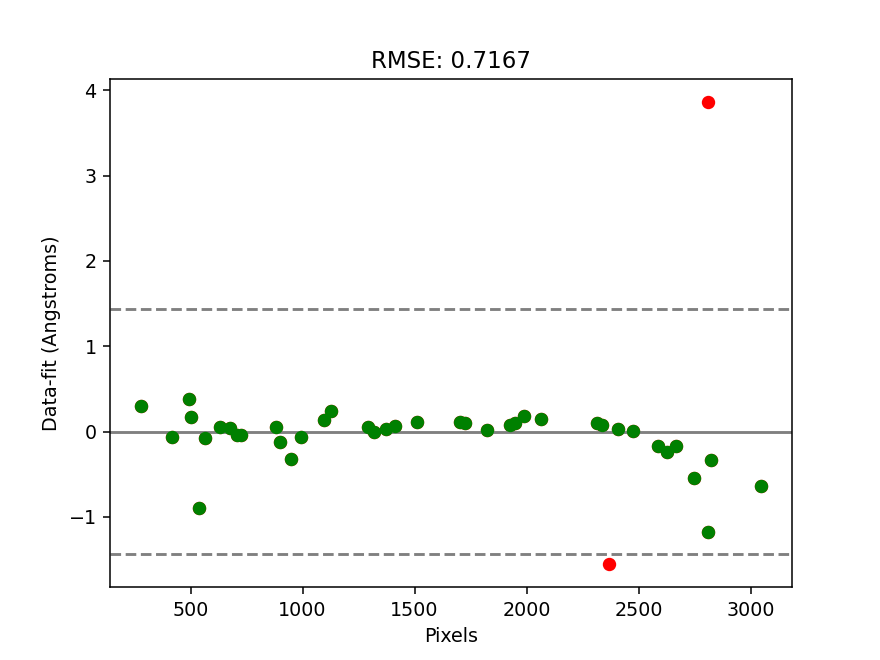

In [14]:
updated_wav,good2,coeffs=calc_fit(3,final_pix, final_wav, 'Polynomial Regression')

## The higher order polynomial improved the fit, but there are some points that are more than two standard deviations away (red). Remove these to get a more precise fit.

[ 1.91005217e+04  1.72953217e+00 -6.99166325e-08  7.04509784e-11]
rmse 0.2198887952197228
[ 0  1  2  3  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 37 38]
39
r2 0.9999999759987579
0.13062276529113345


<IPython.core.display.Javascript object>


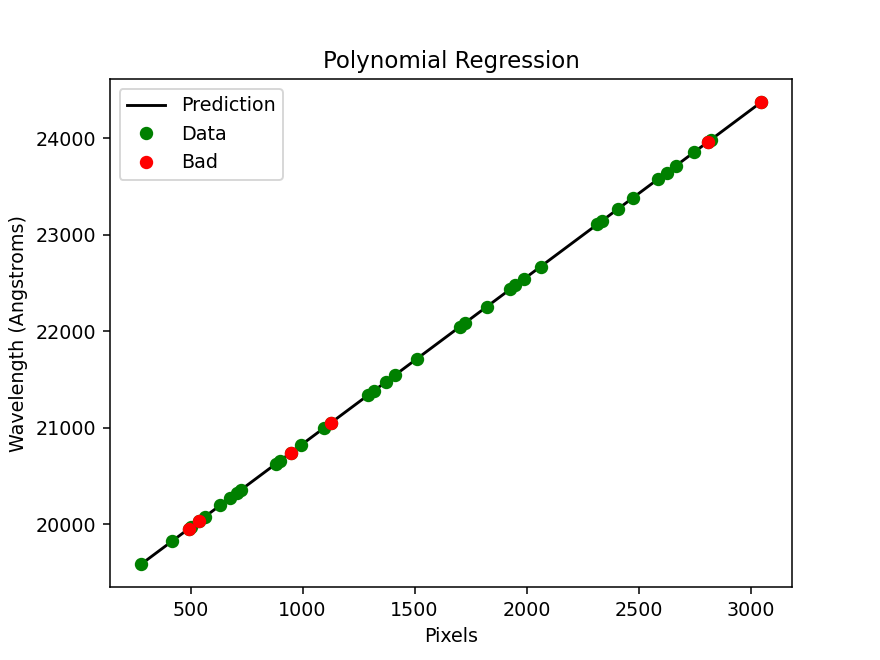

<IPython.core.display.Javascript object>


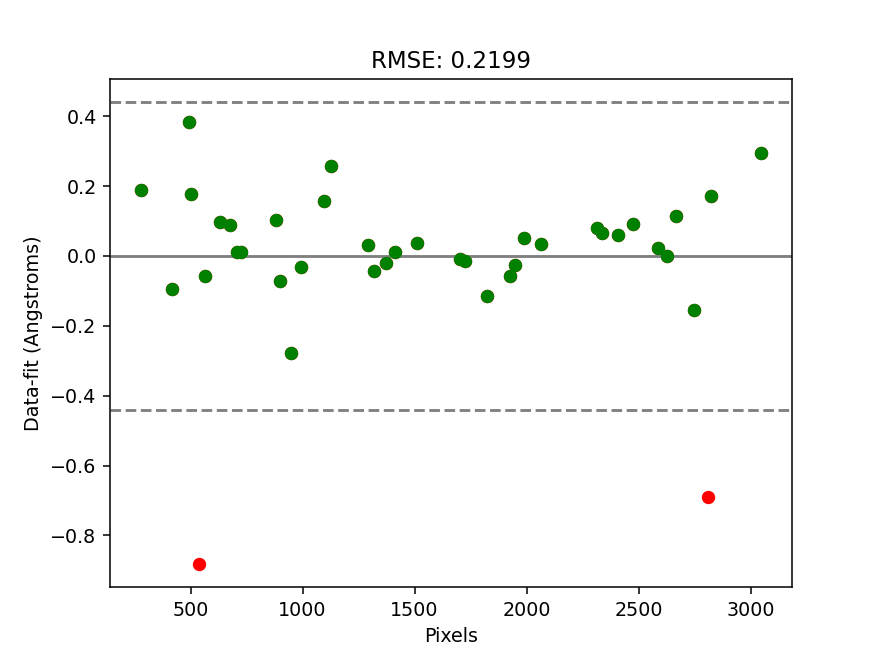

In [15]:
updated_wav,good3,coeffs=calc_fit(3,final_pix[good2],final_wav[good2], 'Polynomial Regression')

## Remove more outliers and repeat the fit. 

[ 1.91007032e+04  1.72934670e+00 -5.57579801e-08  8.59767812e-11]
rmse 0.11312864753094638
[ 0  1  3  4  5  6  7  8  9 10 12 13 15 16 17 18 19 20 21 22 23 24 25 26
 27 28 29 30 31 32 33 35 36]
37
r2 0.9999999933078035
0.07189323597815402


<IPython.core.display.Javascript object>


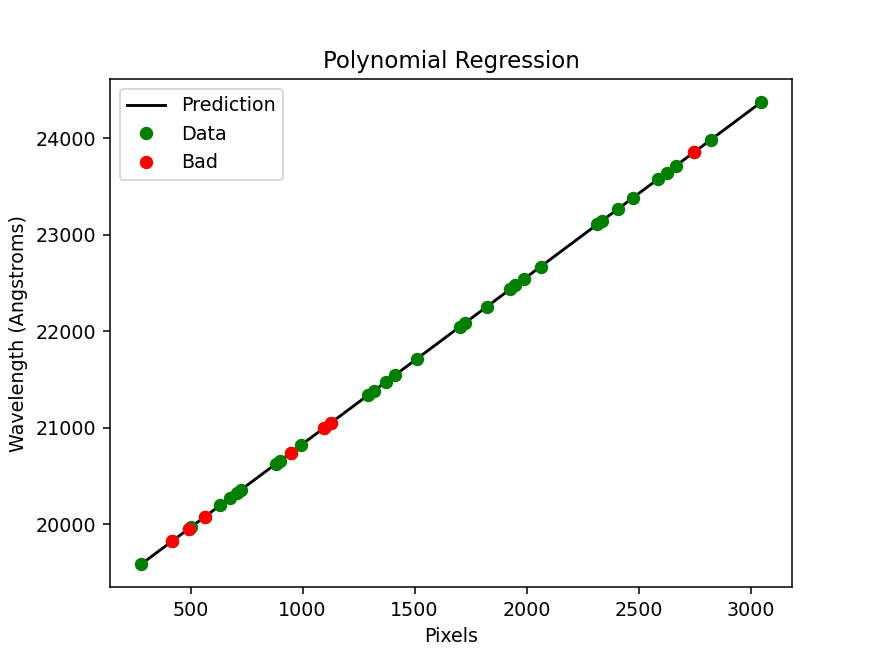

<IPython.core.display.Javascript object>


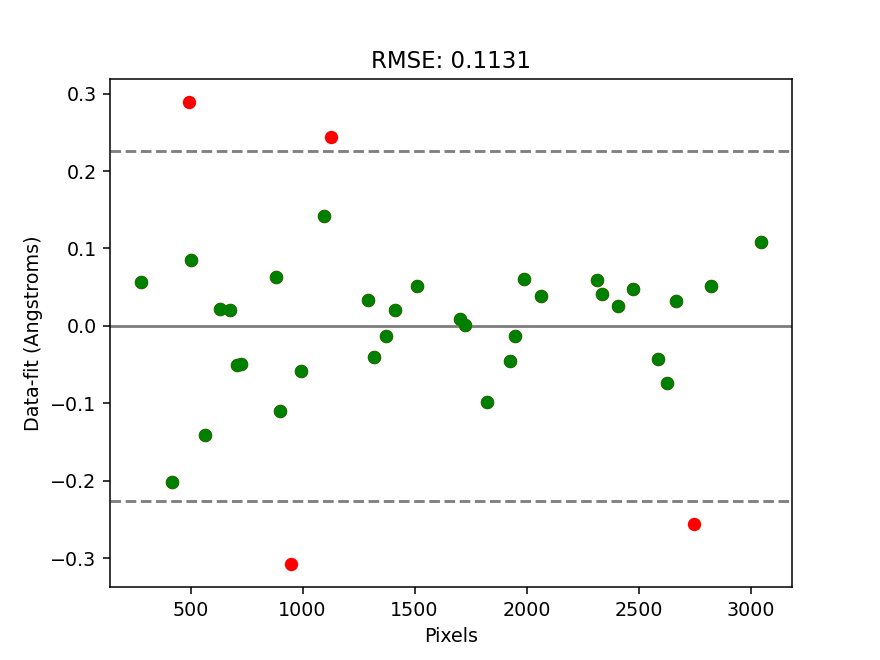

In [16]:
updated_wav,good4,coeffs=calc_fit(3,final_pix[good2][good3],final_wav[good2][good3], 'Polynomial Regression')

## We have reached the required accuracy we need. 

<IPython.core.display.Javascript object>


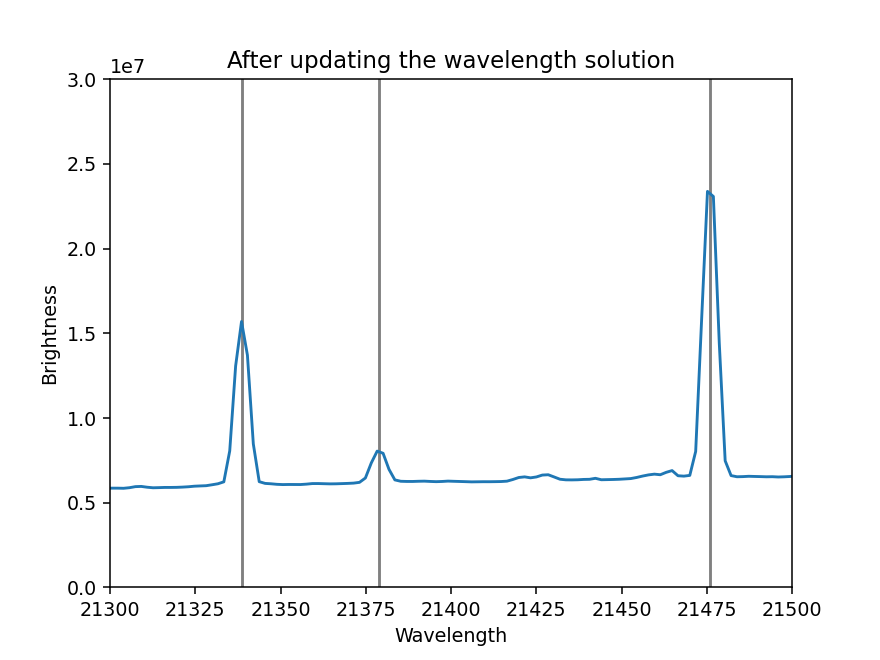

In [17]:
plt.figure()
for l in final_wav[good2][good3]:
    plt.axvline(l,c='gray')
plt.plot(updated_wav,arc)#,label='Data with new wavelength solution')
plt.xlabel('Wavelength')
plt.ylabel('Brightness')
# plt.legend()
plt.title('After updating the wavelength solution')
plt.xlim(21300,21500);
plt.ylim(0,.3e8);

## The data are now well centered on the expected wavelengths.